## How to use analysis tools (example DESC script)
This goes alongside Keith's very useful tutorial to add in notes on the desc nersc environment as well as to summarise how to get started

First note: the appropriate Kernel for this script is desc-stack-weekly-latest


In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
#import analysis tools
import lsst.analysis.tools

# import butler
from lsst.daf.butler import Butler

Peter has provided a test dataset on nersc at the below location (note this may not last indefinitely)

In [21]:
# get a test dataset

repo = "/project/projectdirs/m1727/pferguso/repos/rc2_subset/SMALL_HSC/"
collection = "u/pferguso/step3"

butler = Butler(repo, collections=[collection])
registry = butler.registry

In [22]:
# looking at the data 
dataId = {"tract": 9813, "instrument": "hsc"}
objectTable = butler.get("objectTable_tract", dataId=dataId)
objectTable

column,detect_fromBlend,xy_flag,shape_xx,coord_ra,detect_isDeblendedSource,ebv,detect_isDeblendedModelSource,y,refBand,refExtendedness,...,g_kronFlux_flag,g_kronFlux_flag_bad_radius,g_kronFlux_flag_bad_shape,g_kronFlux_flag_bad_shape_no_psf,g_kronFlux_flag_edge,g_kronFlux_flag_no_fallback_radius,g_kronFlux_flag_no_minimum_radius,g_kronFlux_flag_small_radius,g_kronFlux_flag_used_minimum_radius,g_kronFlux_flag_used_psf_radius
objectId,,,,,,,,,,,,,,,,,,,,,
3495976385350991873,False,True,2.384094,150.343013,True,0.016590,False,15905.000000,i,NaN,...,True,False,True,False,True,False,False,False,False,False
3495976385350991874,False,False,3.789157,150.324119,False,0.016336,False,15930.681871,i,1.0,...,False,False,False,False,False,False,False,False,False,False
3495976385350991875,False,True,2.402837,150.322839,True,0.016331,False,15905.000000,i,NaN,...,True,False,True,False,True,False,False,False,False,False
3495976385350991876,False,True,4.333193,150.308222,False,0.016222,False,15910.000000,i,NaN,...,True,False,True,False,True,False,False,False,False,False
3495976385350991877,False,True,3.687260,150.304626,True,0.016201,False,15905.000000,i,NaN,...,True,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495967589257999448,False,False,1.293504,150.530385,False,0.016220,True,19261.722163,g,0.0,...,False,False,False,False,False,False,False,True,False,True
3495967589257999449,False,False,NaN,150.652532,False,0.018730,True,19271.093431,g,1.0,...,True,False,True,False,False,False,False,False,False,False
3495967589257999450,False,False,6.530649,150.526234,False,0.016180,True,19285.886664,g,1.0,...,False,False,False,False,False,False,False,False,False,False


To run analysis tools metrics it's fairly simple, first we import the necessary metrics, and then initialize the class, pass it the data and band information and then look at the results. 

In [23]:
from lsst.analysis.tools.analysisMetrics import ShapeSizeFractionalMetric
from lsst.analysis.tools.analysisPlots import ShapeSizeFractionalDiffScatterPlot
from lsst.analysis.tools.tasks.base import _StandinPlotInfo

In [24]:
metric = ShapeSizeFractionalMetric()
results = metric(objectTable, band='i')
for key in results.keys():
    print(results[key])

i_highSNStars_median: nan pix
i_highSNStars_sigmaMad: nan pix
i_highSNStars_count: 0.0 ct
i_lowSNStars_median: 0.0002112836378229632 pix
i_lowSNStars_sigmaMad: 0.004690152845331068 pix
i_lowSNStars_count: 225.0 ct


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Plots are a tiny bit more complicated, we need to turn off the summary plot (so we can work with analysis tools directly without relying on a butler), and then we can call the plot as before. 

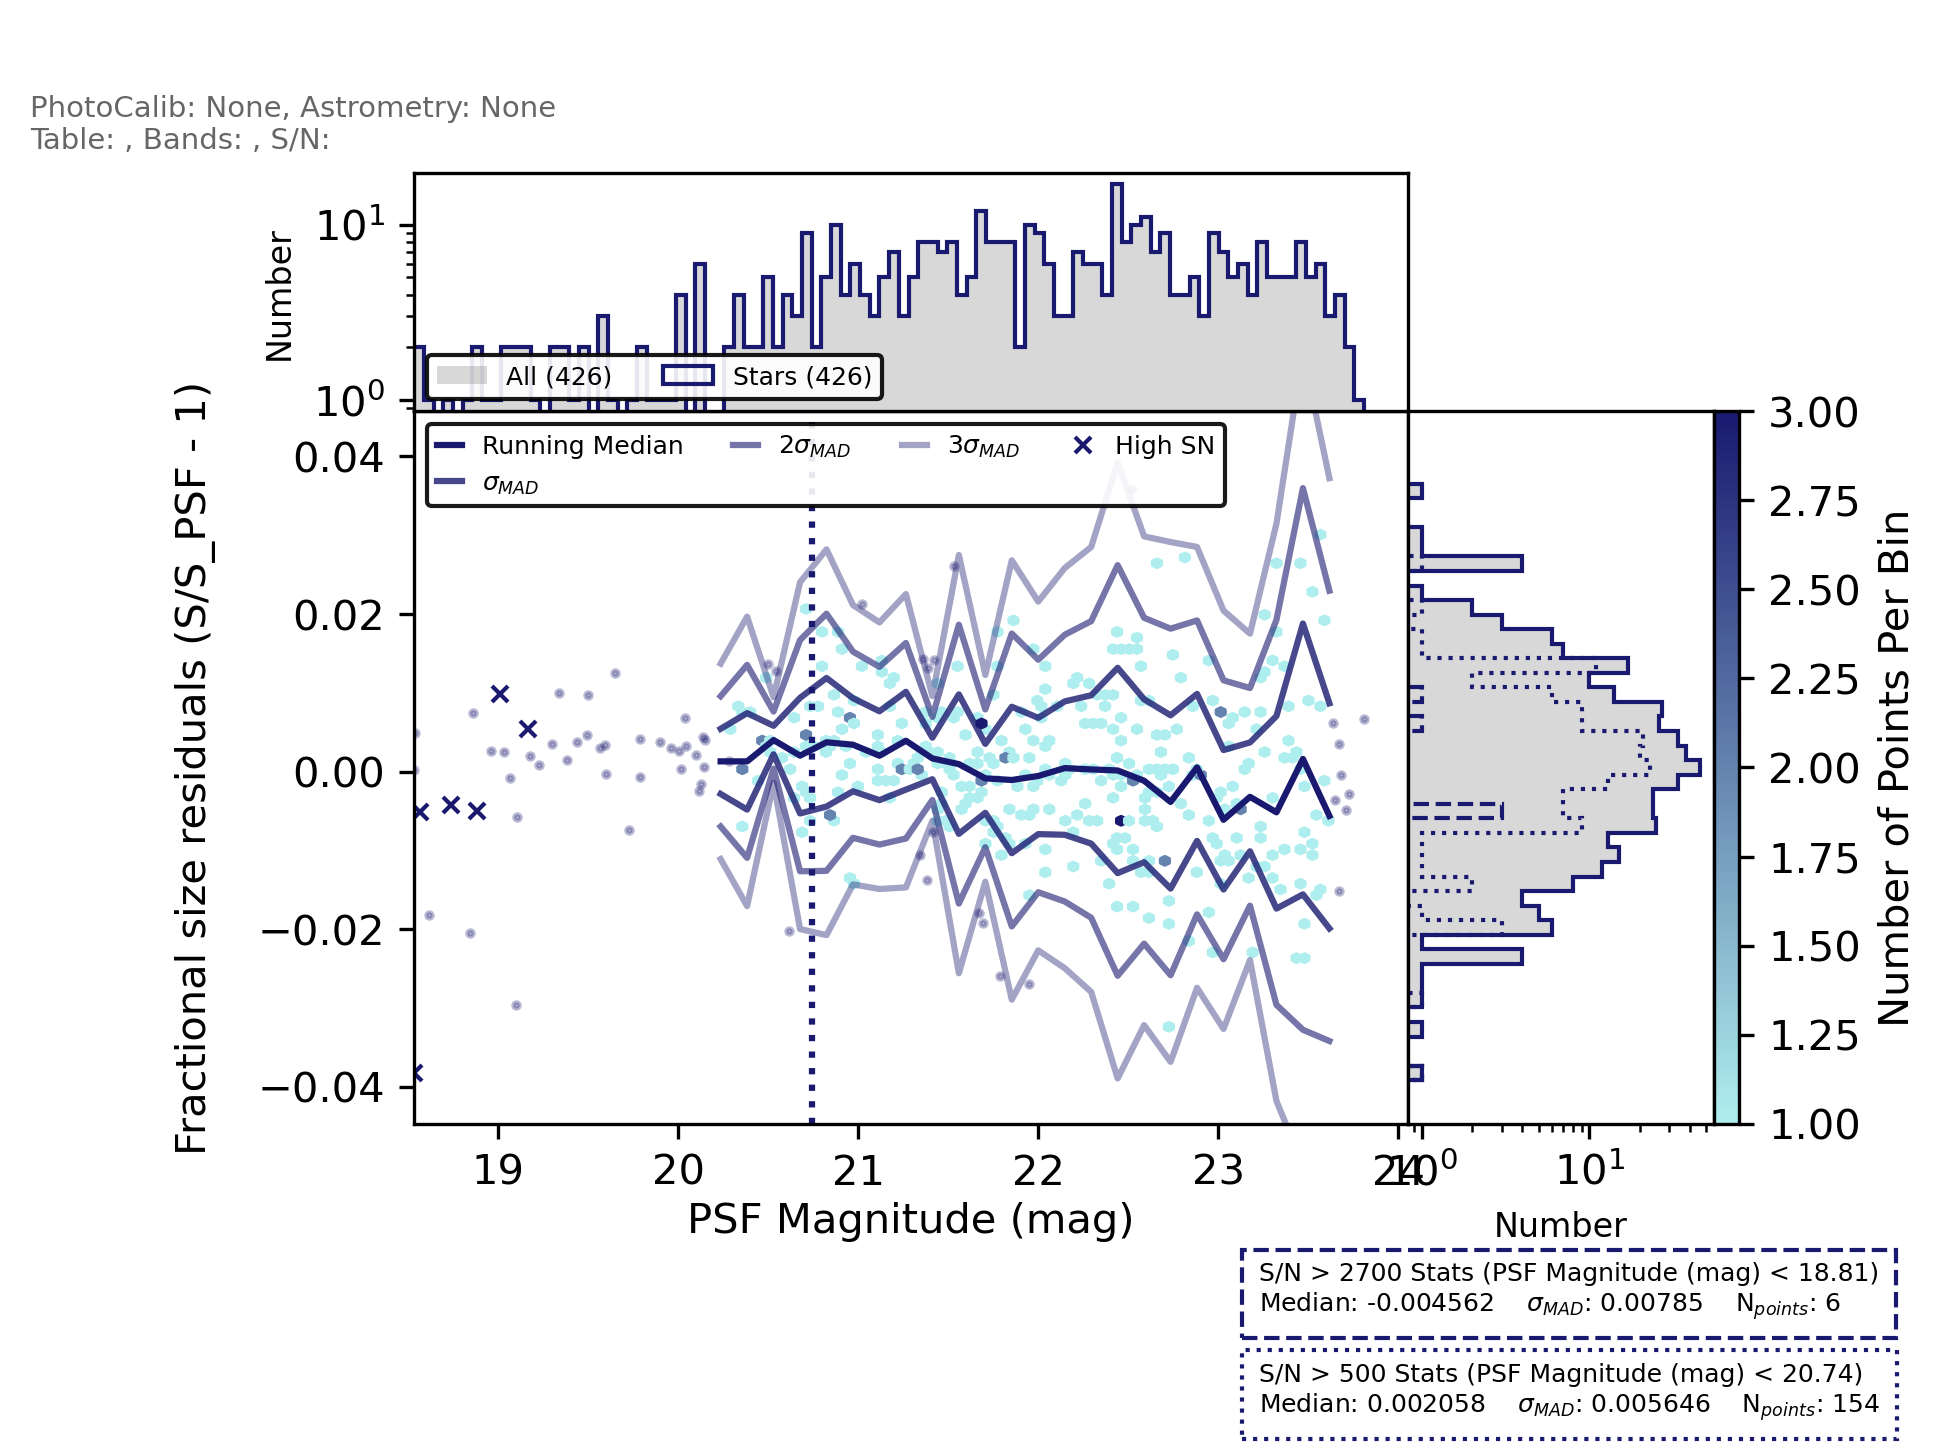

In [25]:
plot = ShapeSizeFractionalDiffScatterPlot()
plot.produce.addSummaryPlot = False
results = plot(objectTable, band='g', skymap=None, plotInfo=_StandinPlotInfo())

## Demo example
This is the demo from Keith's notebook showing how to input our own data and define our own metric. You can use this to play around with different selectors, actions etc, and pass data in a straightforward way. The data needs to be keyed with an appropriate name, or the configuration changed so that names are overwritten. 

In [15]:
from lsst.analysis.tools.actions.scalar import MedianAction
from lsst.analysis.tools.actions.vector import SnSelector
from lsst.analysis.tools.interfaces import AnalysisMetric

class DemoMetric(AnalysisMetric):
    def setDefaults(self):
        super().setDefaults()
        
        # select on high signal to noise obejcts
        # add in a signal to noise selector
        self.prep.selectors.snSelector = SnSelector()
        
        # set what key the selector should use when deciding SNR
        self.prep.selectors.snSelector.fluxType = "psfFlux"
        
        # select what threshold value is desireable for the selector
        self.prep.selectors.snSelector.threshold = 100
        
        # the final name in the qualification is used as a key to insert
        # the calculation into KeyedData
        self.process.calculateActions.medianValueName = MedianAction(vectorKey="psfFlux")
        
        # tell the metic what the units are for the quantity
        self.produce.units = {"medianValueName": "Jy"}
        
        # Rename the quanity prior to producing the Metric
        # (useful for resuable workflows that set a name toward the end of computation)
        self.produce.newNames = {"medianValueName": "DemoMetric"}

In [16]:
# make some fake data
fluxes = np.random.normal(100000, 100, 500)
data = {"psfFlux": fluxes, "psfFluxErr": np.sqrt(fluxes)}
metric = DemoMetric()(data)
metric

{'DemoMetric': Measurement('DemoMetric', <Quantity 100006.21361112 Jy>)}

In [18]:
metric['DemoMetric'].quantity

<Quantity 100006.21361112 Jy>